Installare monai

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install 'monai[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil, cucim, openslide, pandas, einops, transformers, mlflow, matplotlib, tensorboardX, tifffile, imagecodecs, pyyaml, fire, jsonschema, pynrrd, pydicom, h5py]'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import librerie utili

In [ ]:

import logging
import os
import shutil
import sys
import tempfile
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


import torch
from torch import nn
from PIL import Image
from torch.utils.tensorboard import SummaryWriter


import monai
from monai.data import CacheDataset, Dataset, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    Resized,
    EnsureChannelFirstd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    DataStats,
    Spacingd,
    AsDiscreted,
    LabelToMaskd,
    RandRotate90d,
    EnsureType,
    SaveImaged,
    Invertd,
    EnsureTyped,
    ToTensord,
    RandAffined,
    EnsureTyped,
    CenterSpatialCropd    

)

from monai.config import print_config
from monai.utils import first,get_torch_version_tuple, set_determinism
from monai.losses import DiceLoss,DiceCELoss
from monai.networks.nets import UNet, UNETR
from monai.networks.layers import Norm


import segmentation_models_pytorch as smp

print_config()

if get_torch_version_tuple() < (1, 6):
    raise RuntimeError(
        "AMP feature only exists in PyTorch version greater than v1.6."
    )

MONAI version: 1.1.0
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.9.1
gdown version: 4.4.0
TorchVision version: 0.14.1+cu116
tqdm version: 4.64.1
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Set determinism per un training ripetibile

In [ ]:
SEED = 3  
set_determinism(SEED)

Dictionaries

In [ ]:
main_dir = 'drive/MyDrive/tesi/PROVE 2D'
directory= os.path.join(main_dir,'DATASET 2D','all image ridotto (training)')
#directory='drive/MyDrive/tesi/PROVE 2D/DATASET 2D/all image ridotto (training) '

train_IMG_path = sorted(glob(os.path.join(directory,'imagesTr-gamba','*.png')))
train_MASK_path = sorted(glob(os.path.join(directory,'labelsTr-gamba','*.png')))


val_IMG_path = sorted(glob(os.path.join(directory,'imagesVl-gamba','*.png')))
val_MASK_path = sorted(glob(os.path.join(directory,'labelsVl-gamba','*.png')))


train_files = [{"image": image_name, "label": mask_name} for image_name,mask_name in zip(train_IMG_path,train_MASK_path)]
val_files = [{"image": image_name, "label": mask_name} for image_name,mask_name in zip(val_IMG_path,val_MASK_path)]

#train_files = train_files[59:]


In [ ]:

def transformations():
    train_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            #consideriamo le patches contenenti tutta l'immagine per l'allenamento, senza crop

            # RandCropByPosNegLabeld(
            #     keys=["image", "label"],
            #     label_key="label",
            #     spatial_size=[112,112],
            #     pos=1,
            #     neg=1,
            #     num_samples=4,
            #     image_key="image",
            #     image_threshold=0,
            # ),
           
            RandFlipd(
                keys=["image", "label"],
                spatial_axis=[0],
                prob=0.10,
            ),
            RandFlipd(
                keys=["image", "label"],
                spatial_axis=[1],
                prob=0.10,
            ),
            RandRotate90d(
                keys=["image", "label"],
                prob=0.10,
                spatial_axes=[0, 1]
            ),
            RandShiftIntensityd(
                keys=["image"],
                offsets=0.10,
                prob=0.50,
            ),
            ToTensord(keys=["image", "label"])
        ] )      


    #trasformazioni del validation
    val_transforms = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys=["image", "label"]),
            ToTensord(keys=["image", "label"])
        ]
    )
    return train_transforms, val_transforms


def train_process(amp=False):
    train_transforms, val_transforms = transformations()
    train_ds = Dataset(train_files , train_transforms)
    #train_loader = DataLoader( train_ds, batch_size=2)
    train_loader = DataLoader( train_ds, batch_size=2, shuffle=True, num_workers=4)

    val_ds = Dataset(val_files , val_transforms)
    val_loader = DataLoader( val_ds, batch_size=1, num_workers=4)
    
    model_dir = os.path.join(directory,'MODEL_nozeros')

    if not os.path.exists(model_dir):
      os.mkdir(model_dir)
    device =  torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    # model = UNet(
    #     spatial_dims=3,
    #     in_channels=1,
    #     out_channels=2,
    #     channels=(16, 32, 64, 128, 256),
    #     strides=(2, 2, 2, 2),
    #     num_res_units=2,
    #     norm=Norm.BATCH,
    # ).to(device)
    
    model = smp.Unet('resnet50',
                     encoder_depth = 4,
                     encoder_weights= 'imagenet',
                     decoder_channels= ( 128 , 64 , 32 ,16),
                     in_channels = 1, classes=10).to(device)

    loss_function = DiceLoss(to_onehot_y=True,softmax=True)
    
    # model.load_state_dict(torch.load(
    #  os.path.join(model_dir, "best_metric_model_Unet_2d.pth")))
  
    #loss_function = smp.losses.DiceLoss('multiclass',from_logits= True)

    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    scaler = torch.cuda.amp.GradScaler() if amp else None

    post_pred = Compose([Activations(softmax=True ), AsDiscrete(argmax=True, to_onehot=10)])
    post_label = Compose([AsDiscrete(to_onehot=10)])

    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

    max_epochs = 50
    val_interval = 1  # do validation for every epoch
    best_metric = -1
    best_metric_epoch = -1
    
    epoch_loss_values = []
    metric_values = []
   
    
    for epoch in range(max_epochs):
        #epoch_start = time.time()
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            #step_start = time.time()
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            
            optimizer.zero_grad()
            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    #loss = loss_function(outputs, labels)
                    loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
            epoch_loss += loss.item()
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size},"
                f" train_loss: {loss.item():.4f}"
               
            )
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (112,112)
                    sw_batch_size = 4
                    if amp:
                        with torch.cuda.amp.autocast():
                            val_outputs = sliding_window_inference(
                                val_inputs, roi_size, sw_batch_size, model
                            )
                    else:
                        val_outputs = sliding_window_inference(
                            val_inputs, roi_size, sw_batch_size, model
                        )
                    
                    #val_outputs = torch.softmax(val_outputs, dim = 1)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    dice_metric(y_pred=val_outputs, y=val_labels)

                metric = dice_metric.aggregate().item()
                dice_metric.reset()
                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model_Unet_2d.pth"))
                    #torch.save(model.state_dict(), "best_metric_model.pth")
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current"
                    f" mean dice: {metric:.4f}"
                    f" best mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
        
        
    print(
        f"train completed, best_metric: {best_metric:.4f}"
        f" at epoch: {best_metric_epoch}"
        
    )
    return (
        max_epochs,
        epoch_loss_values,
        metric_values,
        
    )

SEED = 3  
set_determinism(SEED)

(
    max_epochs,
    epoch_loss_values,
    metric_values,
    
) = train_process(amp=False)







This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Output streaming troncato alle ultime 5000 righe.
305/437, train_loss: 0.1877
306/437, train_loss: 0.2597
307/437, train_loss: 0.0761
308/437, train_loss: 0.1687
309/437, train_loss: 0.2027
310/437, train_loss: 0.2833
311/437, train_loss: 0.1792
312/437, train_loss: 0.2302
313/437, train_loss: 0.1457
314/437, train_loss: 0.1254
315/437, train_loss: 0.1580
316/437, train_loss: 0.1662
317/437, train_loss: 0.1671
318/437, train_loss: 0.2759
319/437, train_loss: 0.1642
320/437, train_loss: 0.1805
321/437, train_loss: 0.1786
322/437, train_loss: 0.2138
323/437, train_loss: 0.2832
324/437, train_loss: 0.2040
325/437, train_loss: 0.2089
326/437, train_loss: 0.1710
327/437, train_loss: 0.1027
328/437, train_loss: 0.1337
329/437, train_loss: 0.1069
330/437, train_loss: 0.2123
331/437, train_loss: 0.0950
332/437, train_loss: 0.2536
333/437, train_loss: 0.1787
334/437, train_loss: 0.1323
335/437, train_loss: 0.2534
336/437, train_loss: 0.2022
337/437, train_loss: 0.2068
338/437, train_loss: 0.283

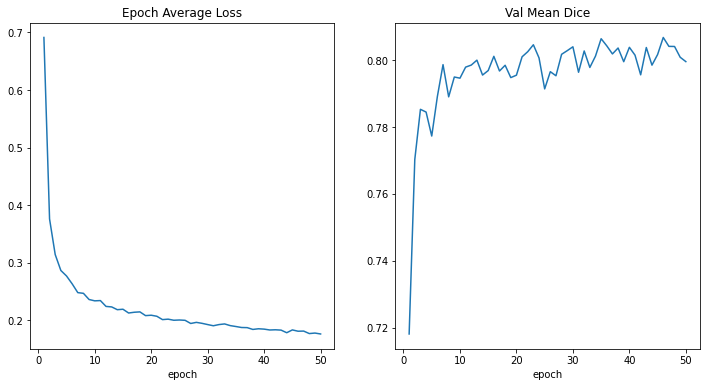

In [ ]:

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [ i + 1 for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()


#ResNet 50

current epoch: 50 current mean dice: 0.7572 best mean dice: 0.7620 at epoch: 33
train completed, best_metric: 0.7620 at epoch: 33
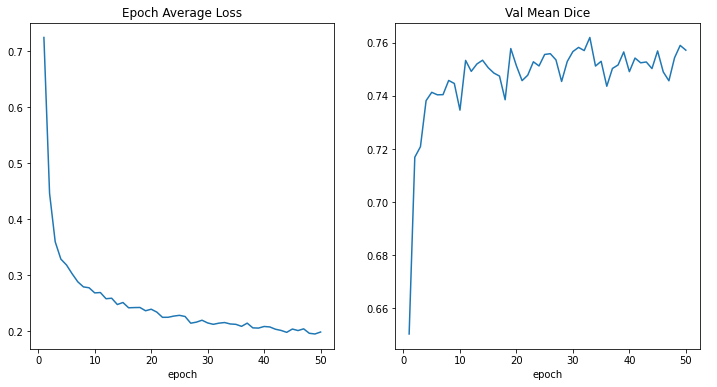

#ResNet 34

#1a generazione
current epoch: 50 current mean dice: 0.7471 best mean dice: 0.7565 at epoch: 32
train completed, best_metric: 0.7565 at epoch: 32
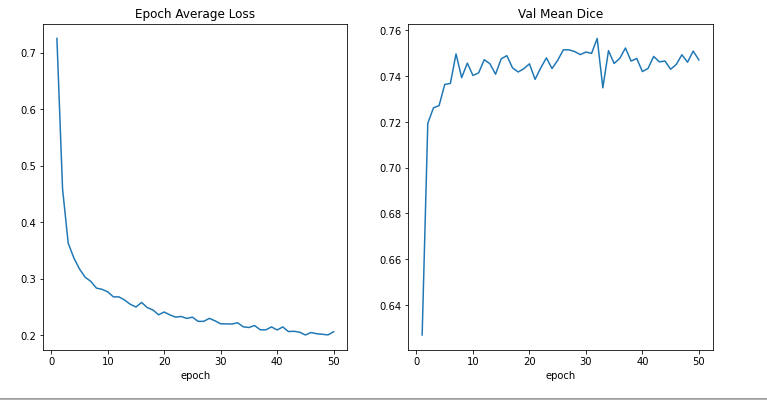

#2a generzione
current epoch: 50 current mean dice: 0.7196 best mean dice: 0.7597 at epoch: 14
train completed, best_metric: 0.7597 at epoch: 14
(allenata per la seconda volta sempre con 50 epoche

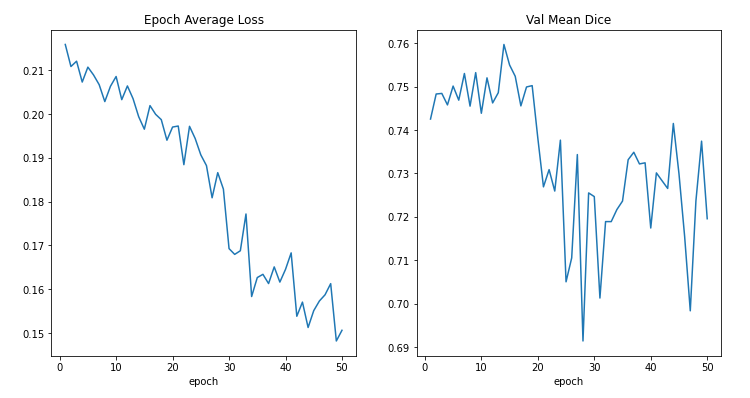

#3a generazione
current epoch: 50 current mean dice: 0.7217 best mean dice: 0.7508 at epoch: 3
train completed, best_metric: 0.7508 at epoch: 3
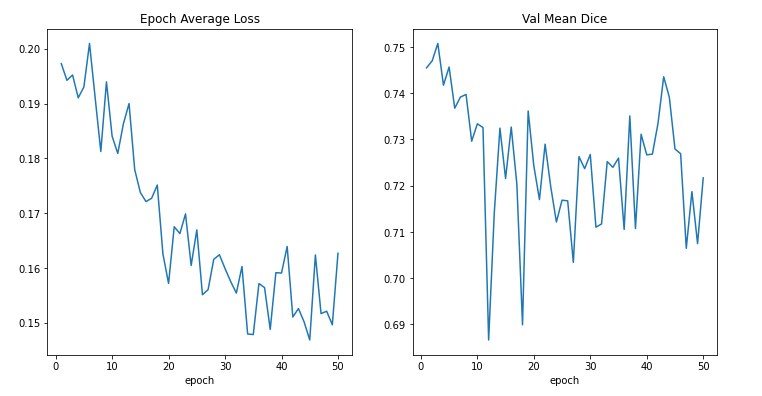